age
sex
body_type (should combine some values)
height (drop too high and too low)
job
location (transform into a boolean livels_in_sanfrancisco)
religion ("add prefer not to say to missing data")
sign ("add prefer not to say to missing data")

In [324]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OrdinalEncoder

# Preprocessing the data and training the model

In [325]:
raw_dataset = pd.read_csv('../data/okcupid.csv') 
okcupid_profiles = raw_dataset.drop(columns="Unnamed: 0") 

As we can see from the output below, almost every column contains object types, which we can not use to fit the Random Forest. 
We need to convert the objects into numbers, and we can do that using OrdinalEncoder from sklearn.
We need to manage the missing data first tho

In [326]:
okcupid_profiles.dtypes

age              int64
status          object
sex             object
orientation     object
body_type       object
diet            object
drinks          object
drugs           object
education       object
ethnicity       object
height         float64
income           int64
job             object
last_online     object
location        object
offspring       object
pets            object
religion        object
sign            object
smokes          object
speaks          object
dtype: object

In [327]:
okcupid_profiles['education'].value_counts()

graduated from college/university    23959
graduated from masters program        8961
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out of ph.d program            127
dropped out

## Filling the missing data

The columns containing missing data are the following:

In [328]:
print(okcupid_profiles.isna().sum())

age                0
status             0
sex                0
orientation        0
body_type       5296
diet           24395
drinks          2985
drugs          14080
education       6628
ethnicity       5680
height             3
income             0
job             8198
last_online        0
location           0
offspring      35561
pets           19921
religion       20226
sign           11056
smokes          5512
speaks            50
dtype: int64


Comparing the missing data output with the dtype output, we can easily see how, except for height, all the missing data are categorical strings.

Since there are only three rows with missing values for height, instead of replacing the NaN with something like 0 or -1, or the average height, we think it's better to just drop them, since it is such a small number

In [329]:
okcupid_profiles = okcupid_profiles.dropna(how = 'any', subset = 'height') 

For all the others attributes, we will just replace the missing values with the 'missing' string.

In [330]:
okcupid_profiles = okcupid_profiles.fillna(value = 'missing')

And now all the columns contain something

In [331]:
print(okcupid_profiles.isna().sum())

age            0
status         0
sex            0
orientation    0
body_type      0
diet           0
drinks         0
drugs          0
education      0
ethnicity      0
height         0
income         0
job            0
last_online    0
location       0
offspring      0
pets           0
religion       0
sign           0
smokes         0
speaks         0
dtype: int64


## Encoding the data

In [332]:
enc = OrdinalEncoder()
enc.fit(okcupid_profiles)

OrdinalEncoder()

In [333]:
encoded_data = enc.transform(okcupid_profiles)

Now we have a Numpy array with the encoded data, so no more objects, but only numbers.

In [334]:
encoded_data.dtype

dtype('float64')

# Random Forest

## Education prediction model

In [335]:
# remember that now we have a Numpy array

y = encoded_data[:,6] # This should pick the education column

X = encoded_data[:, [1,2,3,4,5,7,8,15,16]] # Pick income and job
# X = np.delete(encoded_data, 11, axis = 1) # This should remove the income colum

# test_size = 0.3   means 70% training set | 30% test set
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

In [336]:
# n_estimators is the number of trees in the forest
rfc = RandomForestClassifier(n_estimators = 50)
rfc.fit(X_train, y_train)
rfc_prediction = rfc.predict(X_test)

In [337]:
print("Random Forest Classification report")
print(classification_report(y_test, rfc_prediction))
print("Random Forest Confusion Matrix")
print(confusion_matrix(y_test, rfc_prediction))

Random Forest Classification report
              precision    recall  f1-score   support

         0.0       0.06      0.01      0.02        97
         1.0       0.33      0.15      0.20       920
         2.0       0.18      0.05      0.08       975
         3.0       0.18      0.06      0.09      1582
         4.0       0.13      0.04      0.07      1740
         5.0       0.71      0.91      0.79     12512
         6.0       0.05      0.01      0.02       157

    accuracy                           0.65     17983
   macro avg       0.23      0.18      0.18     17983
weighted avg       0.55      0.65      0.58     17983

Random Forest Confusion Matrix
[[    1     1     1     5     2    86     1]
 [    2   135     4    12    25   742     0]
 [    0    17    52    19    49   836     2]
 [    3    24    20    95    42  1392     6]
 [    1    24    38    46    78  1550     3]
 [    8   199   168   337   404 11373    23]
 [    2     6     3     8     5   131     2]]


Let's now plot a proper confusion matrix

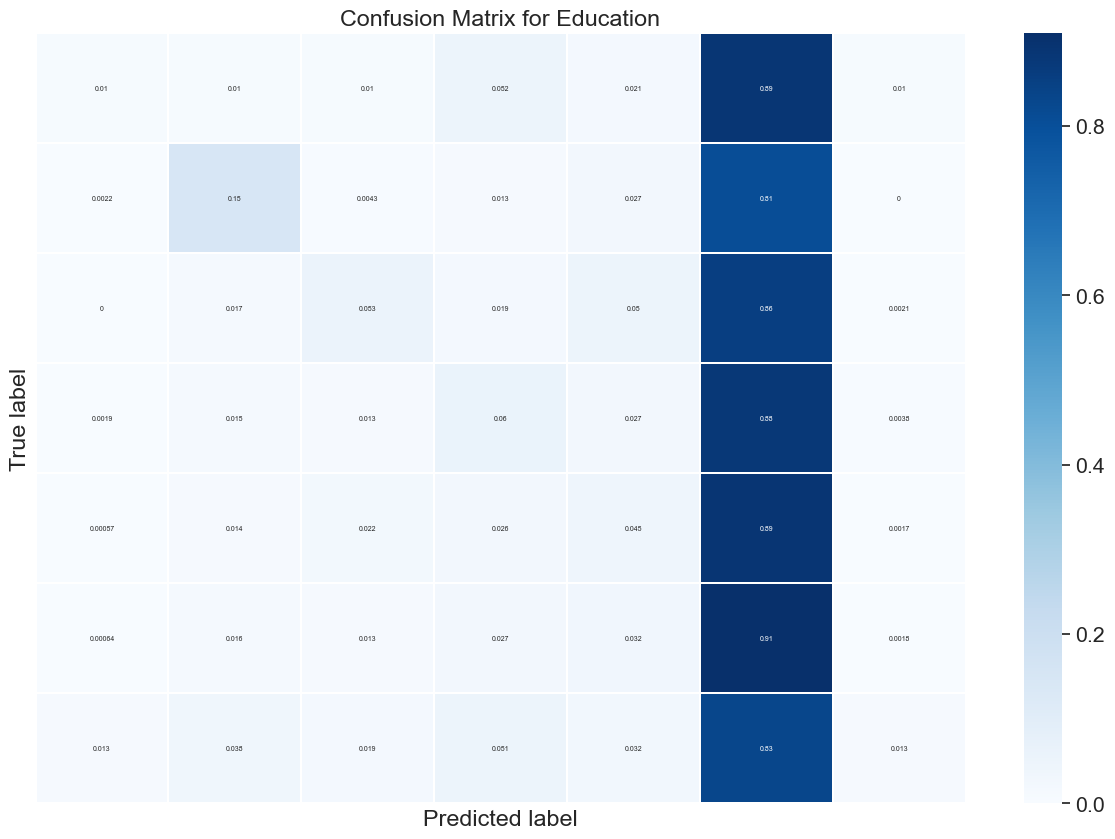

In [338]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, rfc_prediction)

matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis] # makes number into %
#matrix = matrix.astype('float')

# Build the plot
plt.figure(figsize = (15, 10))
sns.set(font_scale = 1.4)
sns.heatmap(matrix, 
            annot = True, 
            annot_kws = {'size':5},
            cmap = plt.cm.Blues, 
            linewidths = 0.2)

# Add labels to the plot
# class_names = np.array(okcupid_profiles["income"].unique())
# class_names = [-1, 80000, 20000, 40000, 30000, 50000, 60000, 1000000, 150000, 100000, 500000, 70000, 250000]
class_names = []

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5

plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks2, class_names, rotation=0)

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.title('Confusion Matrix for Education')
plt.show()